In [ ]:
# This information helps with debugging and getting support :)
import sys, platform
import pandas as pd
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

# 14 - Cement Racking Albedo Improvements

This journal creates a paver underneath the single-axis trackers, and evaluates the improvement for one day -- June 17th with and without the pavers for a location in Davis, CA.

![Paver](../images_wiki/AdvancedJournals/Pavers.PNG)


Measurements:
![Paver](../images_wiki/AdvancedJournals/Pavers_Geometry.PNG)

In [1]:
import os
from pathlib import Path
import pandas as pd

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' / 'Tutorial_14')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_14


In [2]:
from bifacial_radiance import *   
import numpy as np

In [3]:
simulationname = 'tutorial_14'

#Location:
lat = 38.5449 # Davis, CA
lon = -121.7405 # Davis, CA
# MakeModule Parameters
moduletype='test-module'
numpanels = 1  # AgriPV site has 3 modules along the y direction (N-S since we are facing it to the south) .
x = 0.95  
y = 1.838
xgap = 0.02# Leaving 2 centimeters between modules on x direction
ygap = 0.0 # 1 - up 
zgap = 0.06 # gap between modules and torquetube.

# Other default values:

# TorqueTube Parameters
axisofrotationTorqueTube=True
torqueTube = False
cellLevelModule = True

numcellsx = 6
numcellsy = 10
xcell = 0.156
ycell = 0.158
xcellgap = 0.015
ycellgap = 0.015

sensorsy = numcellsy   # one sensor per cell

cellLevelModuleParams = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                         'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}

# SceneDict Parameters
gcr = 0.33 # m
albedo = 0.2  #'grass'     # ground albedo
hub_height = 1.237 # m  
nMods = 20 # six modules per row.
nRows = 3  # 3 row

azimuth_ang = 90 # Facing east 


demo = RadianceObj(simulationname,path = testfolder)  # Create a RadianceObj 'object'
demo.setGround(albedo) #
epwfile = demo.getEPW(lat, lon) 
metdata = demo.readWeatherFile(epwfile, coerce_year=2021) # read in the EPW weather data from above
mymodule=demo.makeModule(name=moduletype,x=x,y=y,numpanels = numpanels, xgap=xgap, ygap=ygap)
mymodule.addCellModule(numcellsx=numcellsx, numcellsy=numcellsy,
                       xcell=xcell, ycell=ycell, xcellgap=xcellgap, ycellgap=ycellgap)


path = C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_14
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_CA_Sacramento.Metro.AP.724839_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos

Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Module was shifted by 0.078 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.85 %
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten



In [4]:
description = 'Sherman Williams "Chantilly White" acrylic paint'
materialpav = 'sw_chantillywhite'
Rrefl = 0.5
Grefl = 0.5 
Brefl = 0.5
demo.addMaterial(material=materialpav, Rrefl=Rrefl, Grefl=Grefl, Brefl=Brefl, comment=description)

Material exists, overwriting...

Added material sw_chantillywhite to file ground.rad


## Simulation without Pavers

In [5]:
timeindex = metdata.datetime.index(pd.to_datetime('2021-06-17 12:0:0 -8'))  # Davis, CA is TZ -8
demo.gendaylit(timeindex)  
    
tilt = demo.getSingleTimestampTrackerAngle(metdata, timeindex=timeindex, gcr=gcr, 
                                   azimuth=180, axis_tilt=0, 
                                   limit_angle=60, backtrack=True)
# create a scene with all the variables
sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
scene = demo.makeScene(module=mymodule, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file.

Created tutorial_14.oct


In [6]:
analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
analysis.analysis(octfile, simulationname+"_noPavers", frontscan, backscan)  # compare the back vs front irradiance  
print("Simulation without Pavers Finished")

Linescan in process: tutorial_14_noPavers_Front
Linescan in process: tutorial_14_noPavers_Back
Saved: results\irr_tutorial_14_noPavers.csv
Simulation without Pavers Finished


## Looping on the day

In [7]:
j=0
starttimeindex = metdata.datetime.index(pd.to_datetime('2021-06-17 7:0:0 -8'))
endtimeindex = metdata.datetime.index(pd.to_datetime('2021-06-17 19:0:0 -8'))
for timess in range (starttimeindex, endtimeindex):
    j+=1
    demo.gendaylit(timess)
    tilt = demo.getSingleTimestampTrackerAngle(metdata, timeindex=timess, gcr=gcr, 
                                       azimuth=180, axis_tilt=0, 
                                       limit_angle=60, backtrack=True)
    # create a scene with all the variables
    sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
    scene = demo.makeScene(module=mymodule, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
    analysis.analysis(octfile, simulationname+"_noPavers_"+str(j), frontscan, backscan)  # compare the back vs front irradiance  
    

Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_1_Front
Linescan in process: tutorial_14_noPavers_1_Back
Saved: results\irr_tutorial_14_noPavers_1.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_2_Front
Linescan in process: tutorial_14_noPavers_2_Back
Saved: results\irr_tutorial_14_noPavers_2.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_3_Front
Linescan in process: tutorial_14_noPavers_3_Back
Saved: results\irr_tutorial_14_noPavers_3.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_4_Front
Linescan in process: tutorial_14_noPavers_4_Back
Saved: results\irr_tutorial_14_noPavers_4.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_5_Front
Linescan in process: tutorial_14_noPavers_5_Back
Saved: results\irr_tutorial_14_noPavers_5.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_6_Front
Linescan in process: tutorial_14_noPavers_6_Back
Saved: results\irr_tutorial_14_n

## Simulation With Pavers

In [8]:
demo.gendaylit(timeindex)
tilt = demo.getSingleTimestampTrackerAngle(metdata, timeindex=timeindex, gcr=gcr, 
                                   azimuth=180, axis_tilt=0, 
                                   limit_angle=60, backtrack=True)
# create a scene with all the variables
sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
scene = demo.makeScene(module=mymodule, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.

In [9]:
torquetubelength = demo.module.scenex*(nMods) 
pitch = demo.module.sceney/gcr
startpitch = -pitch * (nRows-1)/2
p_w = 0.947 # m
p_h = 0.092 # m
p_w2 = 0.187 # m
p_h2 = 0.184 # m
offset_w1y = -(p_w/2)+(p_w2/2)
offset_w2y = (p_w/2)-(p_w2/2)

customObjects = []
for i in range (0, nRows):    
    name='PAVER'+str(i)
    text='! genbox {} paver{} {} {} {} | xform -t {} {} 0 | xform -t {} 0 0'.format(materialpav, i, 
                                    p_w, torquetubelength, p_h, 
                                    -p_w/2, (-torquetubelength+demo.module.sceney)/2.0,
                                    startpitch+pitch*i)
    text += '\r\n! genbox {} paverS1{} {} {} {} | xform -t {} {} 0 | xform -t {} 0 0'.format(materialpav, i,
                                    p_w2, torquetubelength, p_h2, 
                                    -p_w2/2+offset_w1y, (-torquetubelength+demo.module.sceney)/2.0,
                                    startpitch+pitch*i)
    text += '\r\n! genbox {} paverS2{} {} {} {} | xform -t {} {} 0 | xform -t {} 0 0'.format(materialpav, i,
                                    p_w2, torquetubelength, p_h2, 
                                    -p_w2/2+offset_w2y, (-torquetubelength+demo.module.sceney)/2.0,
                                    startpitch+pitch*i)

    customObject = demo.makeCustomObject(name,text)
    customObjects.append(customObject)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")


Custom Object Name objects\PAVER0.rad

Custom Object Name objects\PAVER1.rad

Custom Object Name objects\PAVER2.rad


In [10]:
demo.makeOct()

Created tutorial_14.oct


'tutorial_14.oct'

You can view the geometry generated in the terminal with:

**rvu -vf views\front.vp -e .01 -pe 0.01 -vp -5 -14 1 -vd 0 0.9946 -0.1040 tutorial_14.oct**

In [11]:

## Comment the ! line below to run rvu from the Jupyter notebook instead of your terminal.
## Simulation will stop until you close the rvu window

#!rvu -vf views\front.vp -e .01 -pe 0.01 -vp -5 -14 1 -vd 0 0.9946 -0.1040 tutorial_14.oct


In [12]:
analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
analysis.analysis(octfile, simulationname+"_WITHPavers", frontscan, backscan)  # compare the back vs front irradiance  
print("Simulation WITH Pavers Finished")


Linescan in process: tutorial_14_WITHPavers_Front
Linescan in process: tutorial_14_WITHPavers_Back
Saved: results\irr_tutorial_14_WITHPavers.csv
Simulation WITH Pavers Finished


## LOOP WITH PAVERS

In [13]:
j=0
for timess in range (starttimeindex, endtimeindex):
    j+=1
    demo.gendaylit(timess)
    tilt = demo.getSingleTimestampTrackerAngle(metdata, timeindex=timess, gcr=gcr, 
                                       azimuth=180, axis_tilt=0, 
                                       limit_angle=60, backtrack=True)
    # create a scene with all the variables
    sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
    scene = demo.makeScene(mymodule, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    # Appending Pavers here
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObjects[0], text="!xform -rz 0")
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObjects[1], text="!xform -rz 0")
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObjects[2], text="!xform -rz 0")
    octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
    analysis.analysis(octfile, simulationname+"_WITHPavers_"+str(j), frontscan, backscan)  # compare the back vs front irradiance  
    

Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_1_Front
Linescan in process: tutorial_14_WITHPavers_1_Back
Saved: results\irr_tutorial_14_WITHPavers_1.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_2_Front
Linescan in process: tutorial_14_WITHPavers_2_Back
Saved: results\irr_tutorial_14_WITHPavers_2.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_3_Front
Linescan in process: tutorial_14_WITHPavers_3_Back
Saved: results\irr_tutorial_14_WITHPavers_3.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_4_Front
Linescan in process: tutorial_14_WITHPavers_4_Back
Saved: results\irr_tutorial_14_WITHPavers_4.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_5_Front
Linescan in process: tutorial_14_WITHPavers_5_Back
Saved: results\irr_tutorial_14_WITHPavers_5.csv
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_6_Front
Linescan in process: tutorial_14_WITHPavers_6_Bac

# RESULTS ANALYSIS NOON

In [14]:
df_0 = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_noPavers.csv'))
df_w = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_WITHPavers.csv'))                        

In [15]:
df_0

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio
0,0.772445,4.729862e-17,1.137844,1.116107,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,946.8981,117.24230,0.123817
1,0.601509,3.683183e-17,1.164490,1.142752,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,946.8854,109.52570,0.115669
2,0.430574,2.636503e-17,1.191136,1.169398,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,946.8724,103.41390,0.109216
3,0.259638,1.589824e-17,1.217781,1.196044,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,946.8594,96.69959,0.102127
4,0.088702,5.431448e-18,1.244427,1.222689,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,946.8464,95.68785,0.101059
5,-0.082233,-5.035345e-18,1.271072,1.249335,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,946.8334,95.34497,0.100699
6,-0.253169,-1.550214e-17,1.297718,1.275980,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,947.6977,97.69968,0.103091
7,-0.424105,-2.596893e-17,1.324363,1.302626,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,947.7081,99.91356,0.105426
8,-0.595040,-3.643572e-17,1.351009,1.329271,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,947.7183,105.03310,0.110827
9,-0.765976,-4.690252e-17,1.377654,1.355917,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,947.7285,110.56770,0.116666


In [16]:
df_w

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio
0,0.772445,4.729862e-17,1.137844,1.116107,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,947.1658,125.5783,0.132583
1,0.601509,3.683183e-17,1.164490,1.142752,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,947.2082,119.3176,0.125968
2,0.430574,2.636503e-17,1.191136,1.169398,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,947.2504,114.9427,0.121343
3,0.259638,1.589824e-17,1.217781,1.196044,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,947.2926,110.5928,0.116746
4,0.088702,5.431448e-18,1.244427,1.222689,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,947.3348,112.6003,0.118860
5,-0.082233,-5.035345e-18,1.271072,1.249335,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,947.3168,111.2375,0.117424
6,-0.253169,-1.550214e-17,1.297718,1.275980,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,947.3401,108.4745,0.114504
7,-0.424105,-2.596893e-17,1.324363,1.302626,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,947.3632,109.8079,0.115909
8,-0.595040,-3.643572e-17,1.351009,1.329271,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,947.3864,110.1948,0.116314
9,-0.765976,-4.690252e-17,1.377654,1.355917,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,947.4094,114.2160,0.120556


## Improvement in Rear Irradiance

In [17]:
round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1)

10.3

# RESULT ANALYSIS DAY

In [18]:
df_0 = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_noPavers_1.csv'))
df_w = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_WITHPavers_1.csv'))

In [19]:
df_w

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio
0,0.407436,2.494829e-17,0.573299,0.562299,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,579.8174,27.50550,0.047438
1,0.320937,1.965169e-17,0.723122,0.712122,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,584.6388,27.33312,0.046752
2,0.234436,1.435510e-17,0.872944,0.861944,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,590.6924,27.54174,0.046626
3,0.147936,9.058500e-18,1.022766,1.011766,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,595.0419,26.06395,0.043802
4,0.061437,3.761903e-18,1.172589,1.161589,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,602.6788,26.42415,0.043844
5,-0.025063,-1.534695e-18,1.322411,1.311411,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,606.5762,26.13547,0.043087
6,-0.111563,-6.831292e-18,1.472234,1.461234,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,611.8985,26.60694,0.043483
7,-0.198064,-1.212789e-17,1.622056,1.611056,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,614.5859,26.76097,0.043543
8,-0.284564,-1.742449e-17,1.771878,1.760878,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,620.1961,27.76613,0.044770
9,-0.371063,-2.272108e-17,1.921701,1.910701,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,623.0681,27.96354,0.044880


In [20]:
df_0

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio
0,0.407436,2.494829e-17,0.573299,0.562299,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,581.4525,20.58496,0.035403
1,0.320937,1.965169e-17,0.723122,0.712122,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,584.9100,21.15021,0.036160
2,0.234436,1.435510e-17,0.872944,0.861944,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,592.2502,20.92997,0.035340
3,0.147936,9.058500e-18,1.022766,1.011766,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,596.4415,21.53978,0.036114
4,0.061437,3.761903e-18,1.172589,1.161589,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,603.3365,22.16977,0.036745
5,-0.025063,-1.534695e-18,1.322411,1.311411,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,606.5955,23.02444,0.037957
6,-0.111563,-6.831292e-18,1.472234,1.461234,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,613.5248,23.97887,0.039084
7,-0.198064,-1.212789e-17,1.622056,1.611056,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,617.3268,25.00761,0.040509
8,-0.284564,-1.742449e-17,1.771878,1.760878,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,621.6809,25.92181,0.041696
9,-0.371063,-2.272108e-17,1.921701,1.910701,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,624.8511,26.90095,0.043052


In [21]:
round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1)

16.8

In [22]:
average_back_d0=[]
average_back_dw=[]
average_front = []
hourly_rearirradiance_comparison = []

timessimulated = endtimeindex-starttimeindex

for i in range (1, timessimulated+1):
    df_0 = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_noPavers_'+str(i)+'.csv'))
    df_w = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_WITHPavers_'+str(i)+'.csv'))
    print(round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1))
    hourly_rearirradiance_comparison.append(round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1))
    average_back_d0.append(df_0['Wm2Back'].mean())
    average_back_dw.append(df_w['Wm2Back'].mean())
    average_front.append(df_0['Wm2Front'].mean())
    

16.8
40.7
34.7
23.3
9.3
10.6
10.3
9.7
18.4
32.3
36.5
40.4


In [23]:
print("Increase in rear irradiance: ", round((sum(average_back_dw)-sum(average_back_d0))*100/sum(average_back_d0),1))

Increase in rear irradiance:  20.5


In [24]:
print("BG no Pavers: ", round(sum(average_back_d0)*100/sum(average_front),1))
print("BG with Pavers: ", round(sum(average_back_dw)*100/sum(average_front),1))

BG no Pavers:  8.3
BG with Pavers:  10.0


In [25]:
import matplotlib.pyplot as plt

#metdata.datetime[starttime].hour # 7
#metdata.datetime[endtimeindex].hour # 17
xax= [7, 8, 9, 10, 11, 12,13,14,15,16,17,18]  # Lazy way to get the x axis...


Text(0.5, 0, 'Hour')

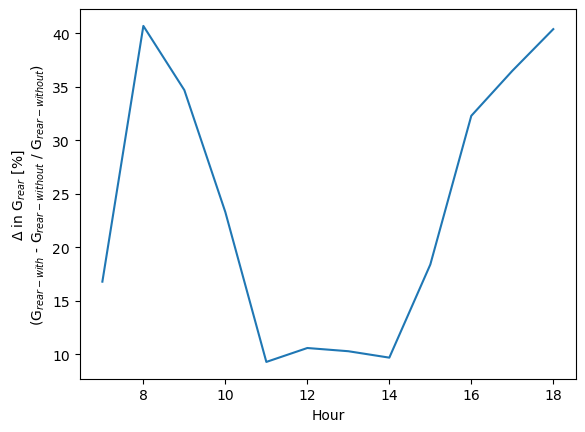

In [26]:
plt.plot(xax,hourly_rearirradiance_comparison)
plt.ylabel('$\Delta$ in G$_{rear}$ [%] \n(G$_{rear-with}$ - G$_{rear-without}$ / G$_{rear-without}$)')
plt.xlabel('Hour')